In [293]:
from extarction import preprocess_data,plot_scatter,save_and_convert_to_gray_scatter
import glob
import pandas as pd

In [294]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.metrics import accuracy_score


In [295]:
dyslexia_folder = "Data/Dyslexic"
control_folder = "Data/Control"

# Function to load data from folder
def load_data_from_folder(folder, label):
    data_list = []
    for filename in os.listdir(folder):
        if filename.endswith(".csv"):
            data = pd.read_csv(os.path.join(folder, filename))
            # Create a unique identifier for each patient based on CSV file name
            data["patient_id"] = filename.split(".")[0]  # Extract patient ID from filename
            data["label"] = label  # Add label column
            data_list.append(data)
    return data_list

# Load dyslexia (D) and control (C) samples
D_data = load_data_from_folder(dyslexia_folder, "dyslexia")
C_data = load_data_from_folder(control_folder, "control")

In [296]:

D_data

[      Unnamed: 0        T        LX        LY        RX        RY patient_id  \
 0              0      0.0   0.00000   0.00000   0.00000   0.00000     111JA2   
 1              1     20.0  -0.00001   0.00000   0.65535  -0.65536     111JA2   
 2              2     40.0  -0.00001  -0.65537   0.65536  -1.31073     111JA2   
 3              3     60.0   0.65536  -1.96609   0.65536  -1.96609     111JA2   
 4              4     80.0   0.65536  -1.96609   1.31072  -1.96609     111JA2   
 ...          ...      ...       ...       ...       ...       ...        ...   
 1994        1994  39880.0  11.14037 -74.05638 -13.76331 -34.07891     111JA2   
 1995        1995  39900.0 -35.39019   9.17552 -47.18667  45.87586     111JA2   
 1996        1996  39920.0 -47.84197  53.08482 -47.18653  53.08482     111JA2   
 1997        1997  39940.0 -47.84185  53.08482 -47.18643  53.08482     111JA2   
 1998        1998  39960.0 -47.84177  53.08482 -47.18636  53.08482     111JA2   
 
          label  
 0     d

In [297]:
C_data

[      Unnamed: 0        T         LX         LY         RX         RY  \
 0              0      0.0    0.00000    0.00000    0.00000    0.00000   
 1              1     20.0    0.65535   -0.00001    0.65536   -0.65536   
 2              2     40.0    0.65534   -0.00001    0.65536   -0.65536   
 3              3     60.0    0.65534   -0.00001    0.65535   -0.65536   
 4              4     80.0    0.65534   -0.00001    0.65534    0.00000   
 ...          ...      ...        ...        ...        ...        ...   
 1494        1494  29880.0  103.54872   37.35520  104.85945   36.69984   
 1495        1495  29900.0  105.51480   36.04447  106.17018   32.76765   
 1496        1496  29920.0  107.48088   27.52472  108.79159   14.41743   
 1497        1497  29940.0  108.13612  -16.38473  102.89310  -78.64416   
 1498        1498  29960.0  104.20380 -135.00506  114.69085 -155.97572   
 
      patient_id    label  
 0        111GM3  control  
 1        111GM3  control  
 2        111GM3  control 

In [298]:
from Print_statements import plot_entire_candidate
import Data_load as dl
import matplotlib.pyplot as plt

In [299]:
#feature_list=['LX', 'LY', 'RX', 'RY']
#C_data, D_data = dl.get_data()
#Full_data = [C_data, D_data]

In [300]:
#print entire data of one candidate
#you can plot of any candidate using the following function:
#plot_entire_candidate(0, 45, Full_data) #(0-Control 1-Dyslexic, number of the candidate)

In [301]:
#plt.plot(C_data[4]['RX'])

In [302]:
print(C_data[0].columns)

Index(['Unnamed: 0', 'T', 'LX', 'LY', 'RX', 'RY', 'patient_id', 'label'], dtype='object')


In [303]:
import os

In [304]:
os.environ['USE_OFFICIAL_TFDLPACK']='true'
os.environ['DGLBACKEND']='tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [305]:
import numpy as np  
import pandas as pd
import dgl

In [306]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [307]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def create_graph_from_data(data_tuple):
    data, _ = data_tuple  # Extract the DataFrame (data) from the tuple
    G = nx.Graph()
    
    # Add nodes (gaze coordinates) to the graph
    for index, row in data.iterrows():
        node_attrs = {'LX': row['LX'], 'LY': row['LY'], 'RX': row['RX'], 'RY': row['RY']}
        G.add_node(index, **node_attrs)
    
    # Add edges based on proximity or temporal relationships
    for i in range(len(data) - 1):
        # Calculate Euclidean distance between consecutive gaze points
        coords_i = data.loc[i, ['LX', 'LY', 'RX', 'RY']].values
        coords_next = data.loc[i+1, ['LX', 'LY', 'RX', 'RY']].values
        distance = np.linalg.norm(coords_i - coords_next)
        
        # Add an edge if the distance is below a threshold (adjust threshold as needed)
        if distance < 5:  # Example threshold: connect nodes within 5 pixels distance
            G.add_edge(i, i+1)
    
    # Print graph information for debugging
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())
    
    return G

# Convert C_data and D_data to tuples with a placeholder value
C_data_tuples = [(df, None) for df in C_data]
D_data_tuples = [(df, None) for df in D_data]

# Create graphs for control (C) and dyslexia (D) datasets
C_graphs = [create_graph_from_data(data_tuple) for data_tuple in C_data_tuples]
D_graphs = [create_graph_from_data(data_tuple) for data_tuple in D_data_tuples]

# Plotting the graphs



Number of nodes: 1499
Number of edges: 1000
Number of nodes: 1999
Number of edges: 1564
Number of nodes: 1249
Number of edges: 950
Number of nodes: 1999
Number of edges: 1477
Number of nodes: 1249
Number of edges: 977
Number of nodes: 1249
Number of edges: 756
Number of nodes: 1499
Number of edges: 1109
Number of nodes: 1499
Number of edges: 1161
Number of nodes: 1249
Number of edges: 1000
Number of nodes: 1499
Number of edges: 1142
Number of nodes: 1499
Number of edges: 1105
Number of nodes: 1499
Number of edges: 1014
Number of nodes: 1749
Number of edges: 1414
Number of nodes: 1249
Number of edges: 947
Number of nodes: 1499
Number of edges: 1104
Number of nodes: 1499
Number of edges: 1223
Number of nodes: 1999
Number of edges: 1579
Number of nodes: 1499
Number of edges: 1169
Number of nodes: 1499
Number of edges: 1201
Number of nodes: 1499
Number of edges: 1086
Number of nodes: 1499
Number of edges: 1207
Number of nodes: 1499
Number of edges: 1204
Number of nodes: 1499
Number of edge

KeyboardInterrupt: 

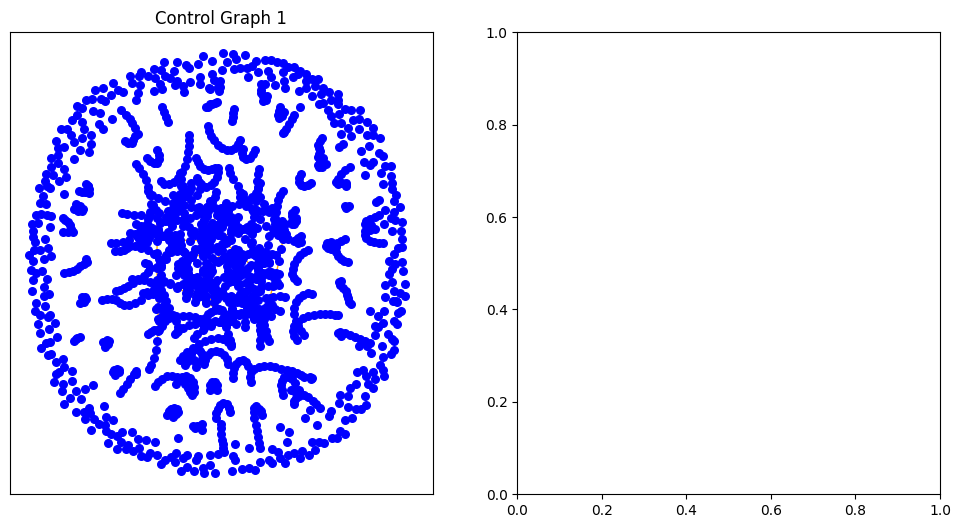

In [308]:
# Define node and edge colors
node_color = 'blue'
edge_color = 'orange'

# Set the size of the nodes (you can adjust this based on your preference)
node_size = 30

# Set the size of the figure (width, height) in inches
plt.figure(figsize=(12, 6))  # Adjust the width and height as needed

# Plot the first graph from the control (C) dataset
G_c = C_graphs[0]
plt.subplot(1, 2, 1)
pos_c = nx.spring_layout(G_c)
nx.draw_networkx_nodes(G_c, pos_c, node_color=node_color, node_size=node_size)
nx.draw_networkx_edges(G_c, pos_c, edge_color=edge_color)
plt.title("Control Graph 1")

# Plot the first graph from the dyslexia (D) dataset
G_d = D_graphs[0]
plt.subplot(1, 2, 2)
pos_d = nx.spring_layout(G_d)
nx.draw_networkx_nodes(G_d, pos_d, node_color=node_color, node_size=node_size)
nx.draw_networkx_edges(G_d, pos_d, edge_color=edge_color)
plt.title("Dyslexia Graph 1")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [309]:
import networkx as nx

In [310]:
for i, G in enumerate(C_graphs):
    adj_matrix = nx.to_numpy_array(G)
    print("\nAdjacency Matrix:")
    print(adj_matrix)

for i, G in enumerate(D_graphs):
    adj_matrix = nx.to_numpy_array(G)
    print("\nAdjacency Matrix:")
    print(adj_matrix)


Adjacency Matrix:
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Adjacency Matrix:
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]

Adjacency Matrix:
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Adjacency Matrix:
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]

Adjacency Matrix:
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]

Adjacency Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 

In [311]:
import networkx as nx

# Function to assign node labels (either 'Control' or 'Dyslexia') to a NetworkX graph
def assign_node_labels(graph, label_type):
    for node in graph.nodes:
        graph.nodes[node]['label'] = label_type

# Assign 'Control' labels to nodes in control (C) graphs
for G in C_graphs:
    assign_node_labels(G, 'Control')

# Assign 'Dyslexia' labels to nodes in dyslexia (D) graphs
for G in D_graphs:
    assign_node_labels(G, 'Dyslexia')

# Example: Retrieve and print node labels for specific nodes in control (C) graphs
labeled_nodes_C = [0, 1]  # Example nodes of interest in control graphs
for i, G in enumerate(C_graphs):
    node_labels_C = {node: G.nodes[node]['label'] for node in labeled_nodes_C if node in G.nodes}
    print(f"Node labels for Control Graph {i+1} (Nodes {labeled_nodes_C}): {node_labels_C}")

# Example: Retrieve and print node labels for specific nodes in dyslexia (D) graphs
labeled_nodes_D = [2, 3]  # Example nodes of interest in dyslexia graphs
for i, G in enumerate(D_graphs):
    node_labels_D = {node: G.nodes[node]['label'] for node in labeled_nodes_D if node in G.nodes}
    print(f"Node labels for Dyslexia Graph {i+1} (Nodes {labeled_nodes_D}): {node_labels_D}")


Node labels for Control Graph 1 (Nodes [0, 1]): {0: 'Control', 1: 'Control'}
Node labels for Control Graph 2 (Nodes [0, 1]): {0: 'Control', 1: 'Control'}
Node labels for Control Graph 3 (Nodes [0, 1]): {0: 'Control', 1: 'Control'}
Node labels for Control Graph 4 (Nodes [0, 1]): {0: 'Control', 1: 'Control'}
Node labels for Control Graph 5 (Nodes [0, 1]): {0: 'Control', 1: 'Control'}
Node labels for Control Graph 6 (Nodes [0, 1]): {0: 'Control', 1: 'Control'}
Node labels for Control Graph 7 (Nodes [0, 1]): {0: 'Control', 1: 'Control'}
Node labels for Control Graph 8 (Nodes [0, 1]): {0: 'Control', 1: 'Control'}
Node labels for Control Graph 9 (Nodes [0, 1]): {0: 'Control', 1: 'Control'}
Node labels for Control Graph 10 (Nodes [0, 1]): {0: 'Control', 1: 'Control'}
Node labels for Control Graph 11 (Nodes [0, 1]): {0: 'Control', 1: 'Control'}
Node labels for Control Graph 12 (Nodes [0, 1]): {0: 'Control', 1: 'Control'}
Node labels for Control Graph 13 (Nodes [0, 1]): {0: 'Control', 1: 'Contr

In [312]:
import itertools

In [313]:
import tensorflow as tf
import networkx as nx

# Function to assign node labels (either 'Control' or 'Dyslexia') to a NetworkX graph
def assign_node_labels(graph, label_type):
    for node in graph.nodes:
        graph.nodes[node]['label'] = label_type

# Assign 'Control' labels to nodes in control (C) graphs
for G in C_graphs:
    assign_node_labels(G, 'Control')

# Assign 'Dyslexia' labels to nodes in dyslexia (D) graphs
for G in D_graphs:
    assign_node_labels(G, 'Dyslexia')




In [314]:
def mention_graph_label(graphs, graph_type):
    print(f"Graph Type: {graph_type}")
    for i, graph in enumerate(graphs):
        print(f"Graph {i + 1}: {graph_type}")

# Mention graph label for all control (C) graphs
mention_graph_label(C_graphs, "0")

# Mention graph label for all dyslexia (D) graphs
mention_graph_label(D_graphs, "1")

Graph Type: 0
Graph 1: 0
Graph 2: 0
Graph 3: 0
Graph 4: 0
Graph 5: 0
Graph 6: 0
Graph 7: 0
Graph 8: 0
Graph 9: 0
Graph 10: 0
Graph 11: 0
Graph 12: 0
Graph 13: 0
Graph 14: 0
Graph 15: 0
Graph 16: 0
Graph 17: 0
Graph 18: 0
Graph 19: 0
Graph 20: 0
Graph 21: 0
Graph 22: 0
Graph 23: 0
Graph 24: 0
Graph 25: 0
Graph 26: 0
Graph 27: 0
Graph 28: 0
Graph 29: 0
Graph 30: 0
Graph 31: 0
Graph 32: 0
Graph 33: 0
Graph 34: 0
Graph 35: 0
Graph 36: 0
Graph 37: 0
Graph 38: 0
Graph 39: 0
Graph 40: 0
Graph 41: 0
Graph 42: 0
Graph 43: 0
Graph 44: 0
Graph 45: 0
Graph 46: 0
Graph 47: 0
Graph 48: 0
Graph 49: 0
Graph 50: 0
Graph 51: 0
Graph 52: 0
Graph 53: 0
Graph 54: 0
Graph 55: 0
Graph 56: 0
Graph 57: 0
Graph 58: 0
Graph 59: 0
Graph 60: 0
Graph 61: 0
Graph 62: 0
Graph 63: 0
Graph 64: 0
Graph 65: 0
Graph 66: 0
Graph 67: 0
Graph 68: 0
Graph 69: 0
Graph 70: 0
Graph 71: 0
Graph 72: 0
Graph 73: 0
Graph 74: 0
Graph 75: 0
Graph 76: 0
Graph 77: 0
Graph 78: 0
Graph 79: 0
Graph 80: 0
Graph 81: 0
Graph 82: 0
Graph 83: 0

In [208]:
import tensorflow as tf
import networkx as nx
import numpy as np

# Function to extract node features from a NetworkX graph
def extract_node_features(graph):
    num_nodes = graph.number_of_nodes()
    # Assuming each node has some attributes (e.g., 'LX', 'LY', 'RX', 'RY')
    node_features = [list(graph.nodes[node].values()) for node in range(num_nodes)]
    return tf.constant(node_features, dtype=tf.float32)

# Assuming you have created C_graphs and D_graphs as lists of NetworkX graphs
C_data_tuples = [(df, None) for df in C_data]
D_data_tuples = [(df, None) for df in D_data]

# Create graphs for control (C) and dyslexia (D) datasets
C_graphs = [create_graph_from_data(data_tuple) for data_tuple in C_data_tuples]
D_graphs = [create_graph_from_data(data_tuple) for data_tuple in D_data_tuples]

# Example: Extract node features from the first graph in C_graphs
graph_C = C_graphs[0]  # Assuming you want to work with the first graph in C_graphs
inputs_C = extract_node_features(graph_C)

# Example: Extract node features from the first graph in D_graphs
graph_D = D_graphs[0]  # Assuming you want to work with the first graph in D_graphs
inputs_D = extract_node_features(graph_D)

# Print the node features for the first graph in C_graphs
print("Node features for Control Graph 1:")
print(inputs_C)

# Print the node features for the first graph in D_graphs
print("Node features for Dyslexia Graph 1:")
print(inputs_D)


Number of nodes: 1499
Number of edges: 1000
Number of nodes: 1999
Number of edges: 1564
Number of nodes: 1249
Number of edges: 950
Number of nodes: 1999
Number of edges: 1477
Number of nodes: 1249
Number of edges: 977
Number of nodes: 1249
Number of edges: 756
Number of nodes: 1499
Number of edges: 1109
Number of nodes: 1499
Number of edges: 1161
Number of nodes: 1249
Number of edges: 1000
Number of nodes: 1499
Number of edges: 1142
Number of nodes: 1499
Number of edges: 1105
Number of nodes: 1499
Number of edges: 1014
Number of nodes: 1749
Number of edges: 1414
Number of nodes: 1249
Number of edges: 947
Number of nodes: 1499
Number of edges: 1104
Number of nodes: 1499
Number of edges: 1223
Number of nodes: 1999
Number of edges: 1579
Number of nodes: 1499
Number of edges: 1169
Number of nodes: 1499
Number of edges: 1201
Number of nodes: 1499
Number of edges: 1086
Number of nodes: 1499
Number of edges: 1207
Number of nodes: 1499
Number of edges: 1204
Number of nodes: 1499
Number of edge

In [315]:
print("Summary of Graph Labels:")
print(f"Total Control Graphs: {len(C_graphs)}")
print(f"Total Dyslexia Graphs: {len(D_graphs)}")
print(f"Total Nodes with Control Label: {label_counts['Control']}")
print(f"Total Nodes with Dyslexia Label: {label_counts['Dyslexia']}")

Summary of Graph Labels:
Total Control Graphs: 88
Total Dyslexia Graphs: 98
Total Nodes with Control Label: 130162
Total Nodes with Dyslexia Label: 194902


In [316]:
label_counts

{'Control': 130162, 'Dyslexia': 194902}

In [317]:
import tensorflow as tf

# Assuming you have labels_tensor containing the numerical labels (0 for 'Control', 1 for 'Dyslexia')
# Convert labels to integer type (0 or 1)
labels_tensor = tf.cast(labels_tensor, dtype=tf.int32)

# Clip label values to be within [0, 1]
labels_tensor = tf.clip_by_value(labels_tensor, 0, 1)

# Convert labels_tensor to a numpy array for printing
llabels_array = labels_tensor.numpy()


#print("All Labels:")
#for i, label in enumerate(labels_array):
    #graph_type = 'Control' if label == 0 else 'Dyslexia'
    #print(f"Graph {i + 1}: {label}")

In [318]:
len(labels_tensor)

325064

In [319]:
# Convert labels to integer type (optional)
#labels_tensor = tf.cast(labels_tensor, dtype=tf.int32)

# Clip label values to be within [0, 1] (optional)
#labels_tensor = tf.clip_by_value(labels_tensor, 0, 1)


In [320]:
# Calculate and print the minimum and maximum label values using TensorFlow operations
if len(labels_numeric) > 0:
    min_label_value = tf.reduce_min(labels_tensor).numpy()
    max_label_value = tf.reduce_max(labels_tensor).numpy()
    print("Min label value:", min_label_value)
    print("Max label value:", max_label_value)
else:
    print("No labels found.")


Min label value: 0
Max label value: 1


In [321]:
import tensorflow as tf
import networkx as nx
import numpy as np

# Function to extract node features from a NetworkX graph
def extract_node_features(graph):
    num_nodes = graph.number_of_nodes()
    # Assuming each node has some attributes (e.g., 'LX', 'LY', 'RX', 'RY')
    node_features = [list(graph.nodes[node].values()) for node in range(num_nodes)]
    return tf.constant(node_features, dtype=tf.float32)

# Assuming you have created C_graphs and D_graphs as lists of NetworkX graphs
C_data_tuples = [(df, None) for df in C_data]
D_data_tuples = [(df, None) for df in D_data]

# Create graphs for control (C) and dyslexia (D) datasets
C_graphs = [create_graph_from_data(data_tuple) for data_tuple in C_data_tuples]
D_graphs = [create_graph_from_data(data_tuple) for data_tuple in D_data_tuples]

# Example: Extract node features from the first graph in C_graphs
graph_C = C_graphs[0]  # Assuming you want to work with the first graph in C_graphs
inputs_C = extract_node_features(graph_C)

# Example: Extract node features from the first graph in D_graphs
graph_D = D_graphs[0]  # Assuming you want to work with the first graph in D_graphs
inputs_D = extract_node_features(graph_D)

# Print the node features for the first graph in C_graphs
print("Node features for Control Graph 1:")
print(inputs_C)

# Print the node features for the first graph in D_graphs
print("Node features for Dyslexia Graph 1:")
print(inputs_D)


Number of nodes: 1499
Number of edges: 1000
Number of nodes: 1999
Number of edges: 1564
Number of nodes: 1249
Number of edges: 950
Number of nodes: 1999
Number of edges: 1477
Number of nodes: 1249
Number of edges: 977
Number of nodes: 1249
Number of edges: 756
Number of nodes: 1499
Number of edges: 1109
Number of nodes: 1499
Number of edges: 1161
Number of nodes: 1249
Number of edges: 1000
Number of nodes: 1499
Number of edges: 1142
Number of nodes: 1499
Number of edges: 1105
Number of nodes: 1499
Number of edges: 1014
Number of nodes: 1749
Number of edges: 1414
Number of nodes: 1249
Number of edges: 947
Number of nodes: 1499
Number of edges: 1104
Number of nodes: 1499
Number of edges: 1223
Number of nodes: 1999
Number of edges: 1579
Number of nodes: 1499
Number of edges: 1169
Number of nodes: 1499
Number of edges: 1201
Number of nodes: 1499
Number of edges: 1086
Number of nodes: 1499
Number of edges: 1207
Number of nodes: 1499
Number of edges: 1204
Number of nodes: 1499
Number of edge

In [323]:
import tensorflow as tf
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split

# Function to extract node features from a NetworkX graph
def extract_node_features(graph):
    num_nodes = graph.number_of_nodes()
    node_features = [list(graph.nodes[node].values()) for node in range(num_nodes)]
    return tf.constant(node_features, dtype=tf.float32)

# Function to extract features and labels from a NetworkX graph
def extract_features_and_labels(graph):
    node_features = extract_node_features(graph)
    labels = [graph.nodes[node].get('label', 0) for node in range(graph.number_of_nodes())]
    labels_tensor = tf.constant(labels, dtype=tf.int32)
    return node_features, labels_tensor


In [324]:
#print("List of nodes in the graph:", list(G.nodes))


In [325]:
def extract_node_features(graph):
    num_nodes = graph.number_of_nodes()
    node_features = []

    for node in range(num_nodes):
        # Extract node attributes (values) from the graph
        attrs = list(graph.nodes[node].values())
        
        # Filter and convert attributes to float32
        filtered_attrs = [float(attr) for attr in attrs if isinstance(attr, (int, float))]
        
        if filtered_attrs:
            node_features.append(filtered_attrs)

    if node_features:
        node_features = np.array(node_features, dtype=np.float32)
    else:
        node_features = np.empty((0, 0), dtype=np.float32)

    return node_features


In [326]:
def extract_features_and_labels(graph):
    node_features = extract_node_features(graph)
    num_nodes = len(node_features)

    labels = [graph.nodes[node].get('label', 0) for node in range(num_nodes)]
    labels_tensor = tf.constant(labels, dtype=tf.int32)

    return node_features, labels_tensor


In [349]:
import tensorflow as tf
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split

# Function to extract node features from a NetworkX graph
def extract_node_features(graph):
    num_nodes = graph.number_of_nodes()
    node_features = [list(graph.nodes[node].values()) for node in range(num_nodes)]
    return tf.constant(node_features, dtype=tf.float32)

# Function to extract features and labels from a NetworkX graph
def extract_features_and_labels(graph):
    node_features = extract_node_features(graph)
    labels = [graph.nodes[node].get('label', 0) for node in range(graph.number_of_nodes())]
    labels_tensor = tf.constant(labels, dtype=tf.int32)
    return node_features, labels_tensor


In [350]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Custom GraphSAGE model for NetworkX graphs
class GraphSAGEModel(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGEModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.dense2 = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return x

# Function to extract node features and labels from a NetworkX graph
def extract_features_and_labels(graph):
    num_nodes = graph.number_of_nodes()
    node_features = [list(graph.nodes[node].values()) for node in range(num_nodes)]
    node_features = tf.constant(node_features, dtype=tf.float32)

    labels = [graph.nodes[node].get('label', 0) for node in range(num_nodes)]
    labels = tf.constant(labels, dtype=tf.int32)

    return node_features, labels

# Assuming C_graphs and D_graphs are lists of NetworkX graphs
C_features_labels = [extract_features_and_labels(G) for G in C_graphs]
D_features_labels = [extract_features_and_labels(G) for G in D_graphs]

# Concatenate features and labels for all graphs
all_features = np.concatenate([features for features, labels in C_features_labels] + [features for features, labels in D_features_labels], axis=0)
all_labels = np.concatenate([labels.numpy() for features, labels in C_features_labels] + [labels.numpy() for features, labels in D_features_labels], axis=0)

# Split data into training, validation, and test sets
train_features, test_features, train_labels, test_labels = train_test_split(all_features, all_labels, test_size=0.2, random_state=42)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# Build and compile the GraphSAGE model
input_dim = train_features.shape[1]
hidden_dim = 64
output_dim = 2  # Assuming binary classification
model = GraphSAGEModel(input_dim, hidden_dim, output_dim)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_features, train_labels, epochs=10, validation_data=(val_features, val_labels))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_features, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/10
6502/6502 [==============================] - 19s 3ms/step - loss: 3.5868e-05 - accuracy: 1.0000 - val_loss: 1.1950e-07 - val_accuracy: 1.0000
Epoch 2/10
6502/6502 [==============================] - 18s 3ms/step - loss: 1.1937e-07 - accuracy: 1.0000 - val_loss: 1.1932e-07 - val_accuracy: 1.0000
Epoch 3/10
6502/6502 [==============================] - 18s 3ms/step - loss: 1.1929e-07 - accuracy: 1.0000 - val_loss: 1.1929e-07 - val_accuracy: 1.0000
Epoch 4/10
6502/6502 [==============================] - 18s 3ms/step - loss: 1.1922e-07 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 5/10
6502/6502 [==============================] - 18s 3ms/step - loss: 1.1921e-07 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 6/10
6502/6502 [==============================] - 18s 3ms/step - loss: 1.1921e-07 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 7/10
6502/6502 [==============================] - 18s 3ms/step - loss: 1.192

Epoch 1/10
6502/6502 [==============================] - 17s 3ms/step - loss: 1.1921e-07 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 2/10
6502/6502 [==============================] - 20s 3ms/step - loss: 1.1921e-07 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 3/10
6502/6502 [==============================] - 570s 88ms/step - loss: 1.1921e-07 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 4/10
6502/6502 [==============================] - 17s 3ms/step - loss: 1.1921e-07 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 5/10
6502/6502 [==============================] - 15s 2ms/step - loss: 1.1921e-07 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 6/10
6502/6502 [==============================] - 15s 2ms/step - loss: 1.1921e-07 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 7/10
6502/6502 [==============================] - 16s 3ms/step - loss: 1.1

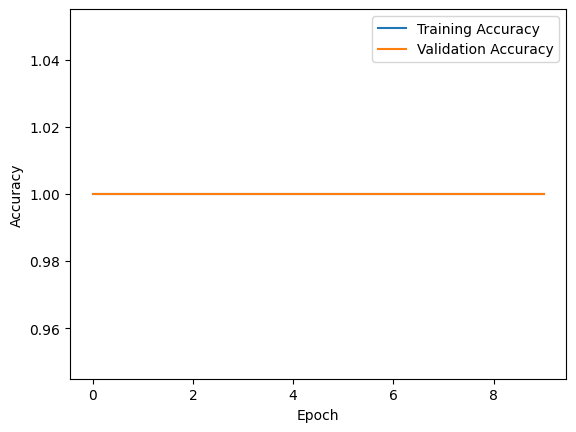

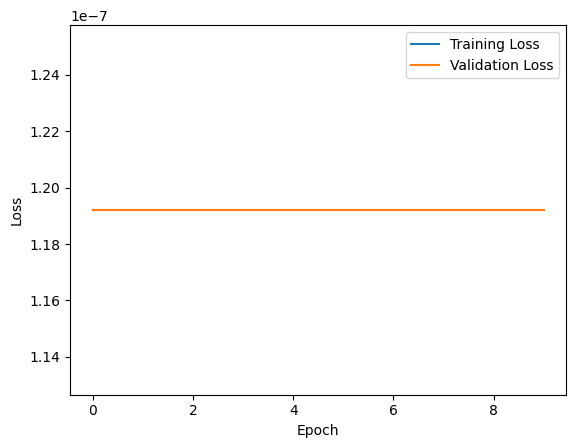

In [195]:
# Train the model and monitor validation metrics
history = model.fit(train_features, train_labels, epochs=10, validation_data=(val_features, val_labels))

# Access training history to plot accuracy and loss over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [351]:
# Evaluate model performance on the test set
test_loss, test_accuracy = model.evaluate(test_features, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


2032/2032 [==============================] - 4s 2ms/step - loss: 4.0922e-07 - accuracy: 1.0000
Test Loss: 4.092178471637453e-07
Test Accuracy: 1.0


In [352]:
model.save('graph_sage_model')

INFO:tensorflow:Assets written to: graph_sage_model\assets


INFO:tensorflow:Assets written to: graph_sage_model\assets


In [353]:
loaded_model = tf.keras.models.load_model('graph_sage_model')

# Then, convert the TensorFlow model into a format that can be serialized by pickle
# For example, you can serialize the model as a dictionary containing weights and architecture
model_data = {
    'architecture': loaded_model.to_json(),
    'weights': loaded_model.get_weights()
}

# Save the model_data dictionary as a .pkl file using pickle
with open('graph_sage_model.pkl', 'wb') as file:
    pickle.dump(model_data, file)


In [366]:
from flask import Flask, render_template, request
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model

app = Flask(__name__)

# Load the trained GraphSAGE model
model1=pickle.load(open('graph_sage_model.pkl','rb'))

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        if 'file' not in request.files:
            return render_template('index.html', message='No file part')

        file = request.files['file']
        if file.filename == '':
            return render_template('index.html', message='No selected file')

        if file:
            try:
                # Preprocess the uploaded CSV file
                node_features = preprocess_data(file)

                # Perform prediction using the loaded model
                predictions = model.predict(node_features)
                predicted_class = np.argmax(predictions)

                # Display result
                result = "Dyslexia detected!" if predicted_class == 1 else "No dyslexia detected."

                return render_template('index2.html', message=result)

            except Exception as e:
                return render_template('index.html', message='Error occurred during prediction.')


In [367]:
if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (windowsapi)


SystemExit: 1

In [358]:
from IPython.display import display, HTML


In [364]:
# Define the HTML content for dyslexia detection form
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Dyslexia Detection</title>
</head>
<body>
    <h1>Dyslexia Detection</h1>
    <form method="POST" action="/predict" enctype="multipart/form-data">
        <input type="file" name="file" accept=".csv"><br><br>
        <input type="submit" value="Upload and Predict">
    </form>
    {% if message %}
    <p>{{ message }}</p>
    {% endif %}
</body>
</html>
"""

# Display the HTML form within the Jupyter Notebook
display(HTML(html_content))
